# Project BBT045
Question:
> How pharmaceutical pollution affect microbial community composition

In [1]:
#Load modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib


# TO DO
- Text hur vi valde saker
- Text hur vi valde inställningar

# Quality control and trimming

## FastQC
The following excerpt from the [fastQC sbatch script](sbatch_files/sbatch_fastqc.sh) was used to run fastQC on all samples except those with "_lake_" in their name in the PROJECT_DATA directory.

In [2]:
%%script false --no-raise-error
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done

## Bash script for trimmomatic

The following excerpt from the trimmomatic sbatch scripts was used to run trimmomatic on all samples except those with "_lake_" in their name in the PROJECT_DATA directory. Because of the different phred-scores used for the samples from 2011 (phred64) and those from 2012 (phred33), two different scripts were used, where the only difference was which files were copied in and which encoding (`--phredXX`) was specified to the trimmomatic command.

Scripts:
- [Trimmomatic script 2011](sbatch_files/sbatch_trimmomatic_2011.sh)
- [Trimmomatic script 2012](sbatch_files/sbatch_trimmomatic_2012.sh)

The trimming done involved (re)converting the encoding to phred33-format, then trimming from the beginning of the read until a base with a quality of at least 30 was encountered. Then the same was done from the end of the read. If the resulting trimmed read was shorter than 60 bases long, the whole read was discarded. Displayed below is a table showing the amount of the reads from a sample where both the forward and reverse reads were kept. The trimming done removed approximately 10 percent of the reads for all samples from 2011 except for "_effluent_point_2011_", where it discarded approximately 23 percent of the reads. The least amount of reads were discarded from "_downstream_1.5km_2012_" where only 3.3 percent of the reads were discarded.

#todo: Remove:?
Paired End Mode:
ref: http://www.usadellab.org/cms/?page=trimmomatic
> trimmomatic PE [-threads <threads>] [-phred33 | -phred64] [-trimlog <logFile>] <input 1> <input 2> <paired output 1> <unpaired output 1> <paired output 2> <unpaired output 2> <step 1> ...

In [3]:
%%script false --no-raise-error
for file in `ls *_1.fastq.gz  | grep -v "_lake_" | sed "s/_1.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC trimmomatic PE -phred64 \
                    $file\_1.fastq.gz $file\_2.fastq.gz \
                    $file\_1.trimmed.fastq.gz $file\_1.un.trimmed.fastq.gz \
                    $file\_2.trimmed.fastq.gz $file\_2.un.trimmed.fastq.gz \
                    TOPHRED33 \
                    LEADING:30 TRAILING:30 \
                    MINLEN:60
done

### Percent of the reads kept
Display the percent of the reads where both the forward and reverse reads are kept after the trimming done above:

In [4]:
# Function since we do it twice, once for each year:
percent_kept_dict = {}
def percent_from_err_file(error_log):
    with open(error_log) as file:
        for line in file:
            if line.startswith(" -phred"): # Locate the "input arguments" line
                # Extract the name from this line:
                name = line.split(" ")[2].removesuffix("_1.fastq.gz")
            elif line.startswith("Input"): # Locate the "output" line
                sample_percent_kept = line.split(" ")[7].strip("()%")
                # Extract the percent kept:
                percent_kept_dict[name] = sample_percent_kept

# Run the functions for the .err file for the trimmomatic jobs
percent_from_err_file("job_logs/2011_job.5791030.err")
percent_from_err_file("job_logs/2012_job.5790995.err")

# Display as a nicer dataframe:
pd.DataFrame.from_dict(percent_kept_dict, orient='index', columns=["Percent_kept"])

,Percent_kept
downstream_17.5km_2011,91.60
downstream_2.3km_2011,89.67
downstream_2.7km_2011,90.55
effluent_point_2011,77.32
upstream_1.9km_2011,88.75
upstream_2.2km_2011,90.02
downstream_1.5km_2012,94.67
upstream_150m_2012,93.92


# FastQC (again)
After the trimming, fastQC was done again, using almost [the same script](sbatch_files/sbatch_fastqc.sh) as before but this time copying in the trimmed fastq files from our group directory instead of the PROJECT DATA directory.

In [5]:
%%script false --no-raise-error
for file in `ls *.fastq.gz | grep -v "_lake_"`
do
    apptainer exec $CONTAINER_LOC fastqc $file -o $WORKING_TMP
done

# Metaphlan4

Running metaphlan4

#todo
Wiki: https://github.com/biobakery/biobakery/wiki/metaphlan4 

In [6]:
%%script false --no-raise-error
for file in `ls *1.trimmed.fastq.gz | sed "s/_1.trimmed.fastq.gz//"`
do
    apptainer exec $CONTAINER_LOC \
        metaphlan $file\_1.trimmed.fastq.gz,$file\_2.trimmed.fastq.gz \
                --input_type fastq --nproc 16 --unclassified_estimation \
                --bowtie2out $file.bowtie2.bz2 -o $file\_profile.txt\
                                            
done

# Visualizing metaphlan output

## Creating clean files
### Merge profile tables

In [7]:
%%script false --no-raise-error

# Merge the _profile tables for each sample into a single file
!merge_metaphlan_tables.py /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/metaphlan/*_profile.txt > data/merged_abundance_table.txt
#ref: https://github.com/biobakery/biobakery/wiki/metaphlan4#16-merging-metaphlan-profiles

# Isolate the species-resolved rows and then remove clutter 
!grep -E "s__|clade_name|UNCLASSIFIED" data/merged_abundance_table.txt |\
    grep -v "t__" |\
    sed "s/^.*|s__//g" |\
    > data/merged_abundance_table_species.txt
#ref https://github.com/biobakery/biobakery/wiki/metaphlan4#211-generate-a-species-only-abundance-table

### Number of species

In [8]:
%%script false --no-raise-error
%%bash

# Create a blank file with a header row:
echo -e "Sample\tspecies_count\ttype\tyear\tread_amount" > data/species_count.txt

# From each profile file, extract the name, type, year and read amount and also calculate 
# the number of unique species in the file, to be used in a dataframe later.
for file in `ls /cephyr/NOBACKUP/groups/bbt045_2024/project_group1/results/metaphlan/*_profile.txt`
do
name=`echo $file | sed "s/.*\///" | sed "s/_201[12]_profile.txt//"`
count=`grep "s__" $file | grep -cv "t__"`
type=`echo $name | sed "s/_.*//"`
year=`echo $file | sed "s/.*\///" | cut -d "_" -f 3`
readAmount=`grep "reads processed" $file | tr -d "[a-z#]"`
echo -e "$name\t$count\t$type\t$year\t$readAmount" >> data/species_count.txt
done

## Create Dataframes

In [9]:
species_file = "data/merged_abundance_table_species.txt"

# Tab separated, first row column names, first column row names
species_df = pd.read_csv(species_file, sep='\t', header=0, index_col=0)

# Extract the unclassified proportion
unclassified__proportion = species_df.iloc[0,:]

# Display the unclassified proportion below:
print("Unclassified proportion:")
print(unclassified__proportion)

# Scale the proportions using the unclassified poportion for each column
species_scaled_df = species_df.div((100-unclassified__proportion)/100)
# Remove the "unclassified" row. 
species_scaled_df = species_scaled_df.drop("UNCLASSIFIED")

# Transpose the dataframes 
species_scaled_df = pd.DataFrame.transpose(species_scaled_df)
species_df = pd.DataFrame.transpose(species_df)

Unclassified proportion:
downstream_1.5km_2012     92.60910
downstream_17.5km_2011    98.59995
downstream_2.3km_2011     97.33405
downstream_2.7km_2011     98.11041
effluent_point_2011       96.75502
upstream_1.9km_2011       98.16720
upstream_150m_2012        88.27704
upstream_2.2km_2011       94.85458
Name: UNCLASSIFIED, dtype: float64


## Heatmap

In [10]:
# Functions to easier plot the heatmaps:
# from: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

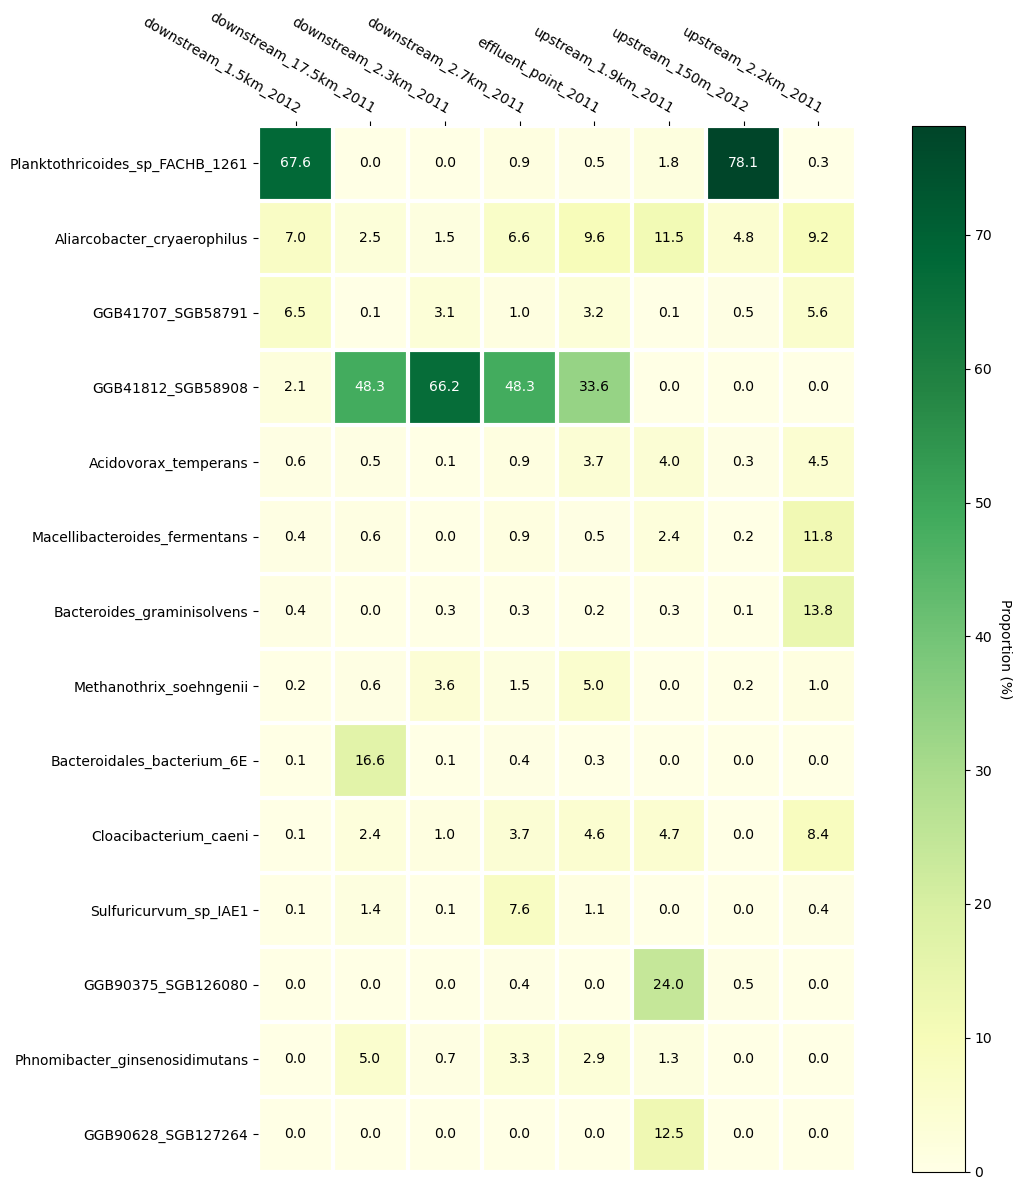

In [11]:
# Select only rows that are deemed to be important based on the condition that the sum of the row is to be larger than 10.
imp_species_scaled_df = species_scaled_df.loc[:, species_scaled_df.sum()>10]

# The dataframe is transposed to have the test sites on the x-axis and the microorganisms on the y-axis
imp_heatmap_df = imp_species_scaled_df.transpose()

# Create the arrays for the functions to use
samples = imp_heatmap_df.index # y axis
species = imp_heatmap_df.columns # x axis
proportion = np.array(imp_heatmap_df) # value in cell

#ref https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
plt.rcParams['figure.figsize'] = [12, 12]

# Plot the heatmap using the functions from above
fig, ax = plt.subplots()
im, cbar = heatmap(proportion, samples, species, ax=ax, #todo Dubbelkolla ordning
                   cmap="YlGn", cbarlabel="Proportion (%)")
texts = annotate_heatmap(im, valfmt="{x:.1f}") #todo Where the values are rounded 

fig.tight_layout()
plt.show()
#plt.savefig("visuals/heatmap.png")

* The column of each sample site adds up to 100%, each value (row) in a column is therefore the percentage each species makes up of the entire sample site composition.
* The cut-off of 10 is chosen to display an appropriate number of microorganisms, this cut-off results in a display of the 14 most abundant species which produces a readable heatmap with a limited number of rows. The decision to use a cut-off of 10 across the rows is to only display the most abundant species, in other words the species that makes up more than 10% across all the sample sites.
* If the pollution affects the microbial community diversity in a negative way we expect the proportions of affected species to be lower in the downstream sample size. This is true for some species, but by far not all. The reasons for a species having higher abundance in the downstream samples could be 1. there are less species and the increased species now makes up a larger proportion. 2. the species increases in abundance because of a positive effect of the pollution. 3. 
* Outliers:
  Planktothrichoides - whose proportion is at elevated levels in the 2012 samples. We speculate that this could be because of a possible algea bloom since this species is a bacterial algea and it occured in only one year. (Need to find source like Johan)
  GGB41812_SGB58908 - makes up a very high abundance in the downstream and effluent samples, but is non-existent (or at least very low) in the upstream samples. The 2012 sample is however much less extreme. Could maybe be due to antibiotic resistance, steroids ??

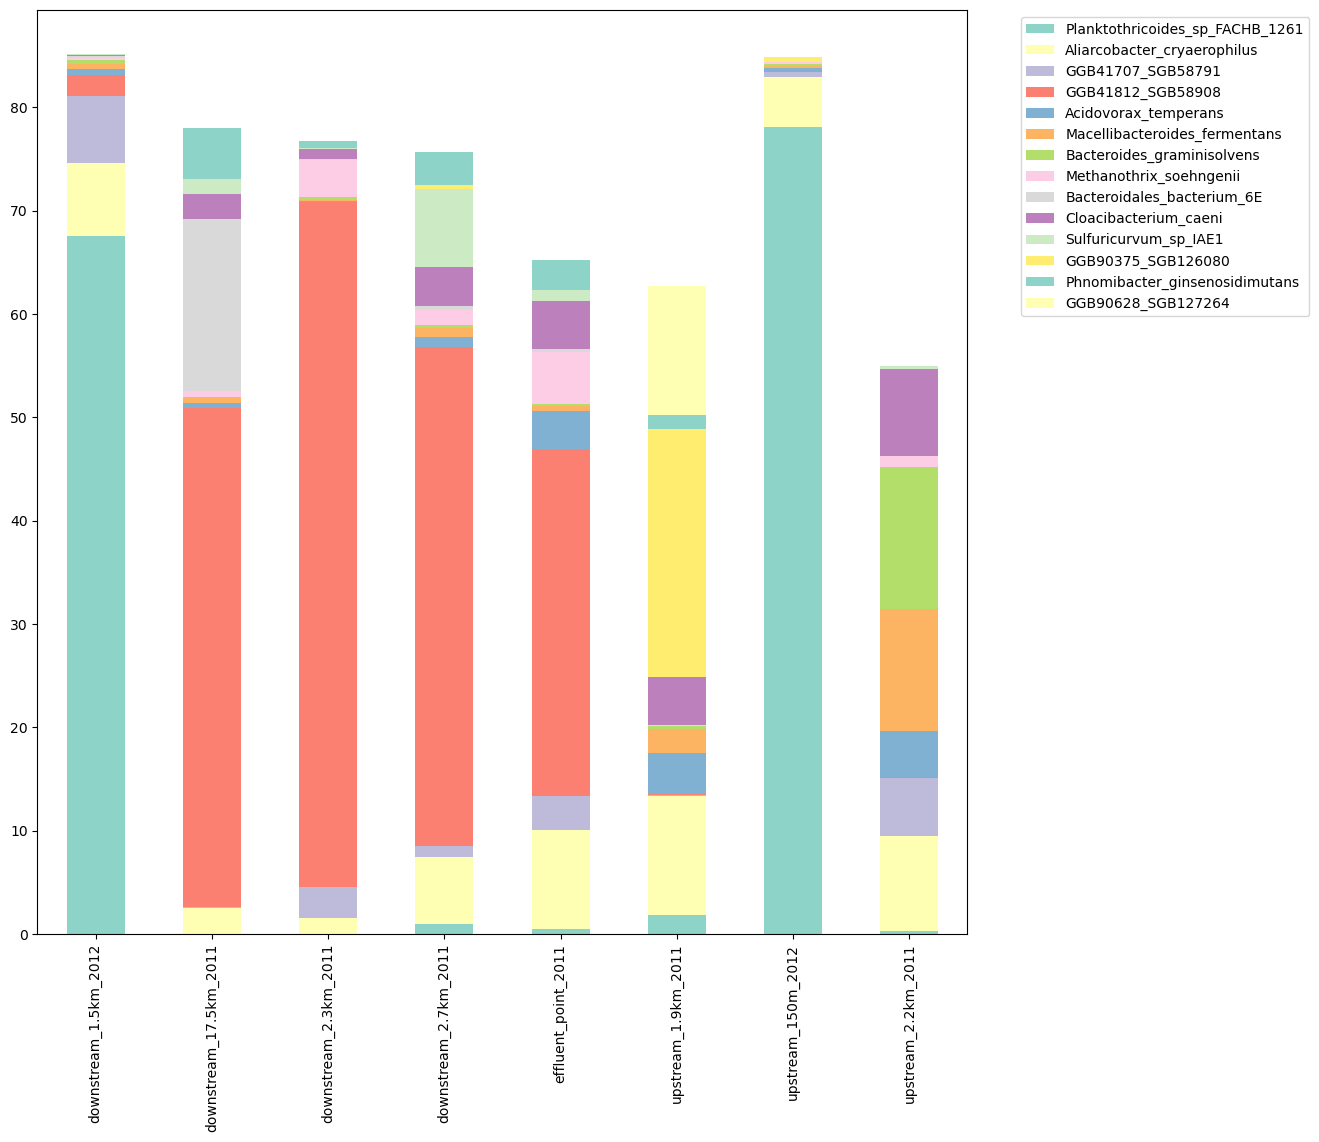

In [12]:
# Transpose the dataframe to plot the correct relation
stacked_bar_chart_df = imp_heatmap_df.transpose()

with sns.color_palette("Set3", n_colors=14):
    stacked_bar_chart_df.plot( 
        kind = 'bar',
        stacked = True, 
        title = '', 
        mark_right = True) 
plt.legend(bbox_to_anchor=(1.05, 1), loc = "upper left")
#plt.savefig("visuals/stacked_barplot.png")

## Species Count

In [13]:
# Tab separated, first row column names, first column row names
count_species = pd.read_csv("data/species_count.txt", sep='\t', header=0)

# Extract only the rows from 2011 #todo Remove?
count_species_2011 = count_species.loc[count_species['year'] == 2011]

min_read_amount = count_species.read_amount.min()

count_species['scaled_read'] = count_species.read_amount/min_read_amount
count_species['scaled_species_count'] = count_species.species_count / count_species.scaled_read
count_species

,Sample,species_count,type,year,read_amount,scaled_read,scaled_species_count
0,downstream_1.5km,78,downstream,2012,34776607,1.412411,55.224703
1,downstream_17.5km,44,downstream,2011,33575959,1.363648,32.266380
2,downstream_2.3km,65,downstream,2011,25647080,1.041626,62.402418
3,downstream_2.7km,91,downstream,2011,66647064,2.706793,33.619121
4,effluent_point,93,effluent,2011,24622151,1.000000,93.000000
5,upstream_1.9km,77,upstream,2011,52915463,2.149100,35.828953
6,upstream_150m,84,upstream,2012,33902189,1.376898,61.006700
7,upstream_2.2km,125,upstream,2011,42785617,1.737688,71.934661


In [14]:
# Apply the default theme
sns.set_theme()
sns.set_style("whitegrid") #todo Example

#sns.catplot(data=count_species, kind="bar", x="Sample", y="species_count", hue="type")
#plt.xticks(rotation=90)
#sns.catplot(data=count_species, kind="bar", x="Sample", y="scaled_species_count", hue="type")
#plt.xticks(rotation=90)
#sns.catplot(data=count_species, kind="bar", x="type", y="species_count")
#sns.catplot(data=count_species, kind="bar", x="type", y="scaled_species_count")
#sns.pairplot(data=count_species, hue="type")

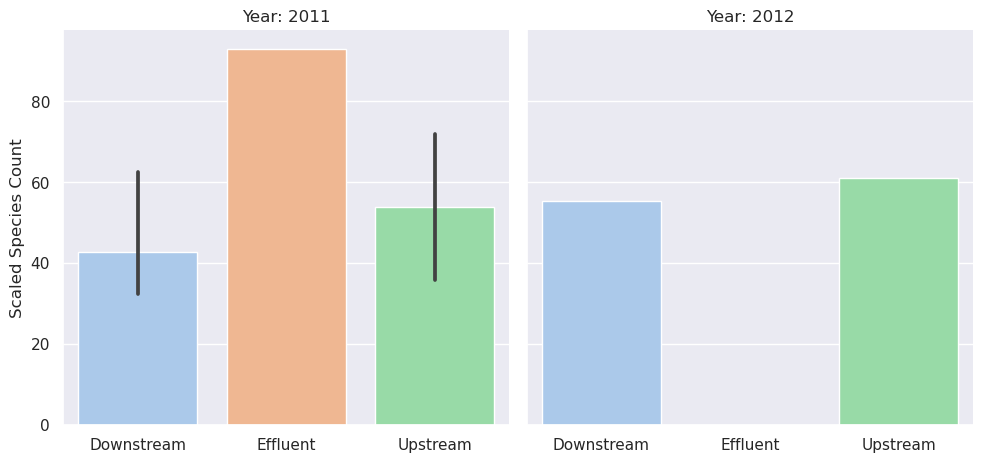

In [15]:
# Apply the default theme
sns.set_theme()
#todo Choose one of these instead?
#sns.set_style("whitegrid") 

# Set the colour palette to "pastel"
sns.set_palette("pastel")

g = sns.catplot(data=count_species, kind="bar", 
                x="type", y="scaled_species_count", 
                col="year")
g.set_axis_labels("", "Scaled Species Count")
g.set_xticklabels(["Downstream", "Effluent", "Upstream"])
g.set_titles("Year: {col_name}")

# Save the plot as a png:
#plt.savefig("species_bars_split.png")

/opt/conda/envs/bbt045-projects/lib/python3.10/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/conda/envs/bbt045-projects/lib/python3.10/site-packages/matplotlib/colors.py:1318: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/conda/envs/bbt045-projects/lib/python3.10/site-packages/matplotlib/colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/opt/conda/envs/bbt045-projects/lib/python3.10/site-packages/matplotlib/ticker.py:372: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


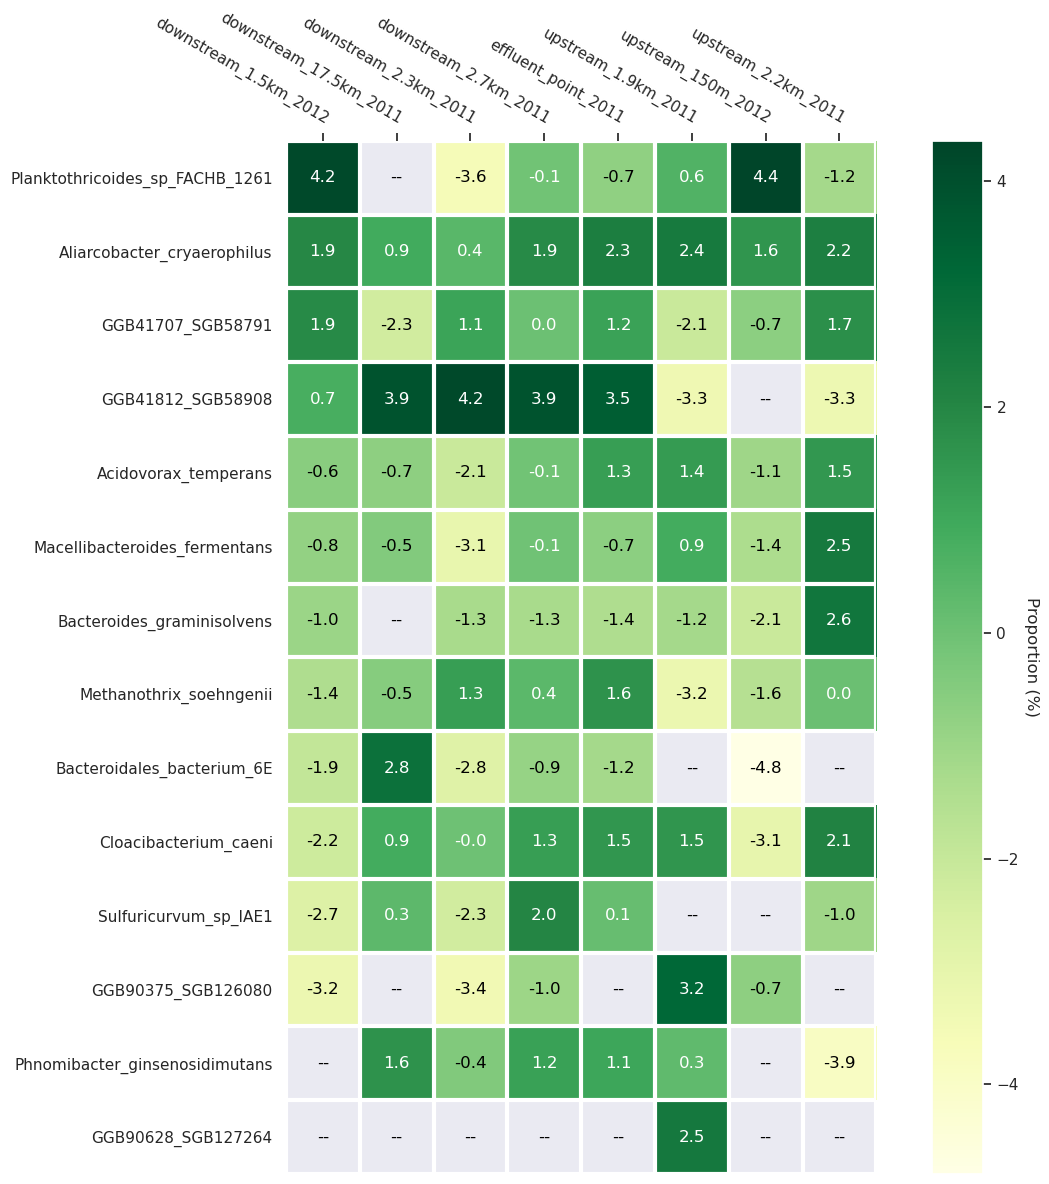

In [16]:
import seaborn as sns
plt.rcParams["axes.grid"]=False # Needed to remove a cross in the middle of the "cells"

#selects only rows that are deemed to be important based on the condition that the sum of the row is to be larger than 10.
imp_species_scaled_log_df = np.log(species_scaled_df.loc[:, species_scaled_df.sum()>10])

#the dataframe is transposed to have the test sites on the x-axis and the microorganisms on the y-axis
imp_heatmap_log_df = imp_species_scaled_log_df.transpose()

# Create the arrays for the functions to use
samples = imp_heatmap_log_df.index # y axis
species = imp_heatmap_log_df.columns # x axis
proportion = np.array(imp_heatmap_log_df) # value in cell

#ref https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
plt.rcParams['figure.figsize'] = [12, 12]

fig, ax = plt.subplots()

im, cbar = heatmap(proportion, samples, species, ax=ax, #todo Dubbelkolla ordning
                   cmap="YlGn", cbarlabel="Proportion (%)")
texts = annotate_heatmap(im, valfmt="{x:.1f}") #todo Where the values are rounded 

fig.tight_layout()
plt.show()
#plt.savefig("heatmap_log.png")

## Calculate Shannon diversity

The tool `calculate_diversity.R` which is built into metaphlan was used tp calculate the shannon diversity for all the samples from the merged abundance table. Unfortunately R was not included in the environment, so instead the utility script was downloaded from [the metaphlan github page](https://github.com/biobakery/MetaPhlAn/blob/master/metaphlan/utils/calculate_diversity.R), and is included in the [scripts folder](scripts/calculate_diversity.R).

The following command was used to generate the file with the diveristy values for all the samples: `Rscript calculate_diversity.R -f data/merged_abundance_table_species.txt -d alpha -m shannon` To this file was then the year and the type manually added, to aid in the visualization below.

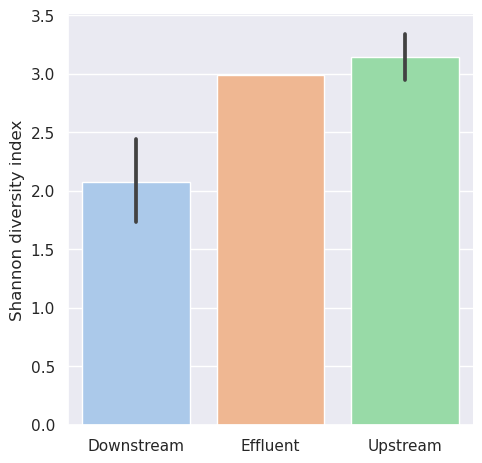

In [17]:
# Tab separated, first row column names, first column row names
shannon_df = pd.read_csv("data/merged_abundance_table_shannon.tsv", sep='\t', header=0)
shannon_df = shannon_df.loc[shannon_df["year"] == 2011, :]

#species_scaled_df.loc[:, species_scaled_df.sum()>10]
# Apply the default theme
sns.set_theme()
#todo Choose one of these instead?
#sns.set_style("whitegrid") 

# Set the colour palette to "pastel"
sns.set_palette("pastel")

g = sns.catplot(data=shannon_df, kind="bar", 
                x="type", y="diversity_shannon")
g.set_axis_labels("", "Shannon diversity index")
g.set_xticklabels(["Downstream", "Effluent", "Upstream"])
plt.savefig("visuals/shannon.png")

In [18]:
with open ('data/pca_data.txt', 'w') as file:
    file.write(species_scaled_df.to_string(index=True, header=True))